# Regularized Linear Models

Before starting the prediction, you need to install xgboost library and please refer to http://xgboost.readthedocs.io/en/latest/build.html#building-on-windows or https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en to install the library.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline

In [2]:
train = pd.read_csv("./Dataset/train.csv")
test = pd.read_csv("./Dataset/test.csv")

In [3]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                   test.loc[:,'MSSubClass':'SaleCondition']))

# Data Preprocessing

In [4]:
# Looking at categorical values
def cat_exploration(column):
    return train[column].value_counts()

# Imputing missing values
def cat_imputation(column, value):
    train.loc[train[column].isnull(),column] = value

train['LotFrontage'].corr(train['LotArea'])
train['SqrtLotArea']=np.sqrt(train['LotArea'])
train['LotFrontage'].corr(train['SqrtLotArea'])
cond = train['LotFrontage'].isnull()
train.LotFrontage[cond]=train.SqrtLotArea[cond]
del train['SqrtLotArea']

basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
for cols in basement_cols:
    if 'FinSF'not in cols:
        cat_imputation(cols,'None')
        
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
for cols in garage_cols:
    if train[cols].dtype==np.object:
        cat_imputation(cols,'None')
    else:
        cat_imputation(cols, 0)

cat_imputation('Alley','None')
cat_imputation('MasVnrType', 'None')
cat_imputation('MasVnrArea', 0.0)
cat_imputation('Electrical','SBrkr')
cat_imputation('FireplaceQu','None')
cat_imputation('PoolQC', 'None')
cat_imputation('Fence', 'None')
cat_imputation('MiscFeature', 'None')

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

/home/zzz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Using sklearn model
We used regularized linear regression models from scikit learn module. 
We are going to try both which is Lasso and Ridge.
Then we defined a function that returns the cross-validation rmse error

In [5]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Now we try to use Ridge model to regularized regression.

In [6]:
model_ridge = Ridge()

We try to insert some parameters to show how flexible our model is by using alpha as main tuning. If the regularization is lower , it means our model will more likely to overfit.

In [7]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

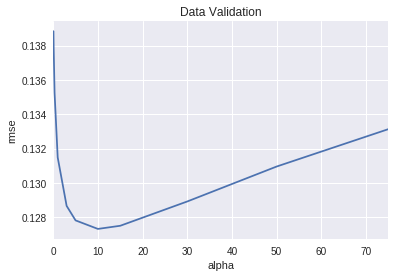

In [8]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Data Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

The graph show that the lowest rmse per alpha is when alpha = 10 which is about right based on the plot above.

In [9]:
cv_ridge.min()

0.12732510679943831

The rmse we get for the Ridge regression is about 0.127

Next , we use Lasso model for the try out. 

In [10]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [11]:
rmse_cv(model_lasso).mean()

0.12320636774053066

Well, the lasso model performs better than ridge model.

In [12]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [13]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 113 variables and eliminated the other 189 variables


In [14]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

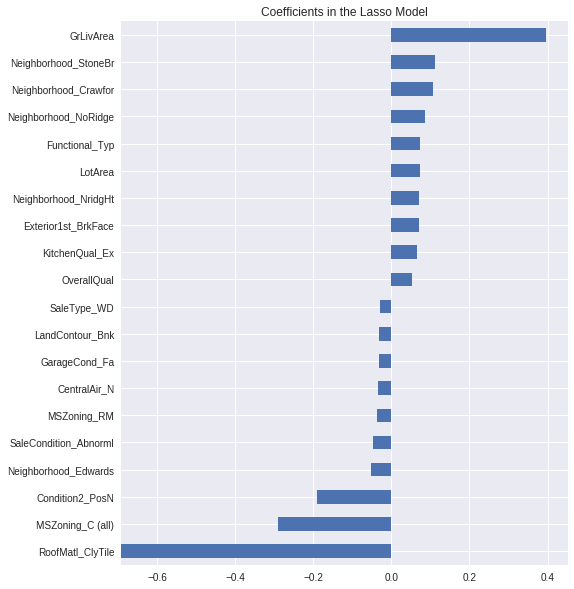

In [15]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Well, throught the graph shown above, we can see that the GrLivArea is the most important positive feature. While the RoofMatl_ClyTile is the most negative feature. Well this make sense as some of the features are not worth looking into as the prediction for SalesPrice.  

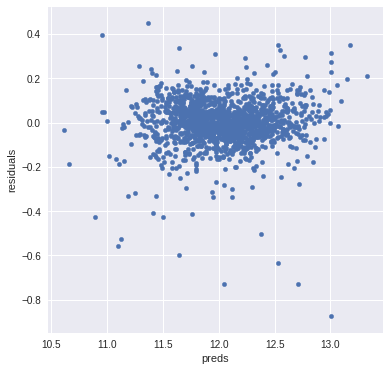

In [16]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# XGBoost (Extreme Gradient Boosting Classifier)
We try to improve the accuracy by adding xgboost library with using tree decision

In [17]:
#import library
import xgboost as xgb

/home/zzz/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The default of max_depth is 6.
The maximum depth of a tree, it is same as GBM(Gradient boosting machine learning from sklearn).
It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. For eta, default=0.3. Analogous to learning rate in GBM. it makes the model more robust by shrinking the weights on each step

In [18]:
#assign train and test set
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

#Set the max_depth to 2 and the eta to 0.1
params = {"max_depth":2, "eta":0.1}
model = xgb.cv
(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

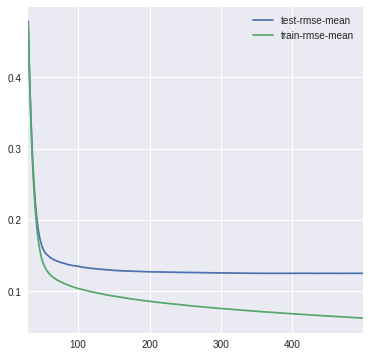

In [19]:
#plot a graph to show root-mean-square error between train and test dataset
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [20]:
#set estimator to 360, maxdepth 2, and learning rate = 0.1
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

np.expm1 is a function provides greater precision than exp(x) - 1 for small values of x. Therefore we used it for greater precision for data prediction.

In [21]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

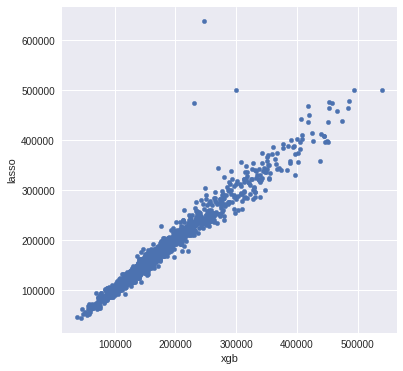

In [22]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [23]:
#80% of prediction from lasso and 20% from xgb
preds = 0.8*lasso_preds + 0.2*xgb_preds

In [24]:
#Generate prediction file
submission = pd.DataFrame({"id":test.Id, "SalePrice":preds})
submission.to_csv("./Submit_csv/testing.csv", index = False)